In [1]:
import argparse
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pycircstat.descriptive as circstat
%matplotlib inline

/Users/richardknoche/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


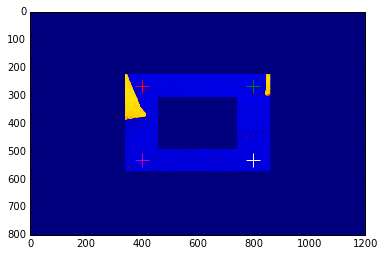

In [2]:
#Using HSV image format
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Blur/Sharp/Couch3.jpg')
I_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
I_v = I_hsv[:,:,2]
I_g = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
I_h = I_hsv[:,:,0]
I_s = I_hsv[:,:,1]

#Get number of row and columns
nrows = image.shape[0]
ncols = image.shape[1]

#Get 1/3rd and 2/3rd row and columns
first_thrd_rows = np.int(np.floor(nrows*1.0/3.0))
second_thrd_rows = np.int(np.floor(nrows*2.0/3.0))
first_thrd_cols = np.int(np.floor(ncols*1.0/3.0))
second_thrd_cols = np.int(np.floor(ncols*2.0/3.0))

#Define areas that are "close" to 1/3rd lines
margin = 20.0
above_first_thrd_rows = np.int(first_thrd_rows - np.floor(nrows/margin))
below_first_thrd_rows = np.int(first_thrd_rows + np.floor(nrows/margin))

above_second_thrd_rows = np.int(second_thrd_rows - np.floor(nrows/margin)) #_i
below_second_thrd_rows = np.int(second_thrd_rows + np.floor(nrows/margin)) #_o

left_first_thrd_cols = np.int(first_thrd_cols - np.floor(ncols/margin))
right_first_thrd_cols = np.int(first_thrd_cols + np.floor(ncols/margin))

left_second_thrd_cols = np.int(second_thrd_cols - np.floor(ncols/margin))
right_second_thrd_cols = np.int(second_thrd_cols + np.floor(ncols/margin))

#Build mask of where center of thirds are
thrds_mask = np.zeros_like(I_h)
thrds_mask[above_first_thrd_rows:below_second_thrd_rows,left_first_thrd_cols:right_second_thrd_cols] = 1
thrds_mask[below_first_thrd_rows:above_second_thrd_rows,right_first_thrd_cols:left_second_thrd_cols] = 0

#Apply mask
test =np.zeros_like(I_h)
test += thrds_mask * I_h

import itertools
t_rows = [first_thrd_rows,second_thrd_rows]
t_cols = [first_thrd_cols,second_thrd_cols]
thrds_coords = list(itertools.product(t_rows, t_cols))

colors=['r','g','m','w']
for (idx,points) in enumerate(thrds_coords):
    plt.scatter(points[1],points[0],color=colors[idx],marker='+',s=200)

plt.imshow(test)

In [3]:
#Note:  When calculating mean of Hue, we have to use circular stats (since mean of 359 and 1 should be zero)
#Mean of an angle on a circle is arg(sum(exp^(i*theta)))
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pySaliencyMap as SMap
import cmath
sm = SMap.pySaliencyMap(image.shape[1], image.shape[0])
saliencymap    = sm.SMGetSM(image)

thrds_hue     = cmath.phase(np.exp((I_h[thrds_mask==1]*np.pi/180)*1j).sum())*(180/np.pi)
thrds_sat      = np.mean(I_s[first_thrd_rows:second_thrd_rows,first_thrd_cols:second_thrd_cols]/255.0)                         
thrds_value    = np.mean(I_v[first_thrd_rows:second_thrd_rows,first_thrd_cols:second_thrd_cols]/255.0)                         
thrds_saliency = np.sum(saliencymap[thrds_mask==1])/np.sum(thrds_mask)

# Rule of thirds symmetry

In [4]:
#From https://pdfs.semanticscholar.org/42b5/33621f2defe97cb6894eefbb6126ce1f2691.pdf
def CalcMaskedSymmetry(src,mask):
    a = src.astype("float")
    b1 = src[::-1,:].astype("float") #Flip upsidedown
    b2 = src[:,::-1].astype("float") #Flip left/right

    #Calculate symmetry by multplying mirrored images
    fs = (a + b2)/2
    fa = (a - b2)/2
    Sym_Horizontal_Value = (fs[mask==1]**2).sum()/((fs[mask==1]**2).sum() + (fa[mask==1]**2).sum())

    fs = (a + b1)/2
    fa = (a - b1)/2
    Sym_Vertical_Value = (fs[mask==1]**2).sum()/( (fs[mask==1]**2).sum() + (fa[mask==1]**2).sum())

    #Instead of 0.5-1, scale from 0-1
    Sym_Horizontal_Value=Sym_Horizontal_Value*2 - 1
    Sym_Vertical_Value=Sym_Vertical_Value*2 - 1

    return(Sym_Horizontal_Value,Sym_Vertical_Value)

Sym_Horizontal_Hue_Thrds,Sym_Vertical_Hue_Thrds = CalcMaskedSymmetry(I_h,thrds_mask)
Sym_Horizontal_Saturation_Thrds,Sym_Vertical_Saturation_Thrds = CalcMaskedSymmetry(I_s,thrds_mask)
Sym_Horizontal_Value_Thrds,Sym_Vertical_Value_Thrds = CalcMaskedSymmetry(I_v,thrds_mask)
Sym_Horizontal_Saliency_Thrds,Sym_Vertical_Saliency_Thrds = CalcMaskedSymmetry(saliencymap,thrds_mask)

# How close is the maximum saliency point to the location of thirds

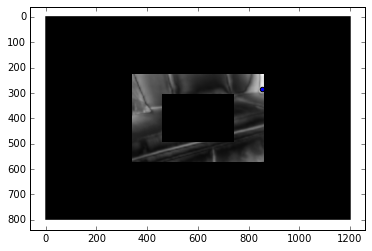

In [5]:
test =np.zeros_like(saliencymap)
test += thrds_mask * saliencymap
(maxs_y,maxs_x) = np.where(saliencymap == np.max(saliencymap))
plt.imshow(test,cmap='gray')
plt.scatter(maxs_x,maxs_y)